# Task 5 - Viral Tweets Prediction Challenge

Débora Mayumi Rissato - 5288223

Douglas Decicino de Andrade - 10883512

Paulino Ribeiro Villas Boas - 2950178

Renan Silva Chun - 10691817

Renan de Oliveira da Cruz - 10801090

Notebook contendo a análise dos dados da competição "Viral Tweets Prediction Challenge" (https://bitgrit.net/competition/12). O objetivo desta competição é desenvolver um modelo de aprendizado de máquina para prever o nível de "viralidade" de cada tweet com base em atributos como conteúdo do tweet, mídia anexada ao tweet e data/hora de publicação.

Abaixo temos o import de algumas bibliotecas que serão utilizadas no decorrer do código.

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate,
                                     train_test_split, GridSearchCV,cross_val_score)
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
#Dados treino
train_tweets = pd.read_csv("Dataset/Tweets/train_tweets.csv")
train_tweets_vectorized_media = pd.read_csv("Dataset/Tweets/train_tweets_vectorized_media.csv")
train_tweets_vectorized_text = pd.read_csv("Dataset/Tweets/train_tweets_vectorized_text.csv")

#Dados teste
test_tweets = pd.read_csv("Dataset/Tweets/test_tweets.csv")
test_tweets_vectorized_media = pd.read_csv("Dataset/Tweets/test_tweets_vectorized_media.csv")
test_tweets_vectorized_text = pd.read_csv("Dataset/Tweets/test_tweets_vectorized_text.csv")

In [3]:
user_vectorized_descriptions = pd.read_csv("Dataset/Users/user_vectorized_descriptions.csv")
user_vectorized_profile_images = pd.read_csv("Dataset/Users/user_vectorized_profile_images.csv")
users = pd.read_csv("Dataset/Users/users.csv")

In [4]:
print(train_tweets_vectorized_media.shape)
print(train_tweets_vectorized_text.shape)
print(train_tweets.shape)

(21010, 2050)
(29625, 769)
(29625, 14)


Abaixo verificamos se os dados contêm valores ausentes.

In [5]:
train_tweets.isnull().mean()

tweet_id                  0.000000
tweet_user_id             0.000000
tweet_created_at_year     0.000000
tweet_created_at_month    0.000000
tweet_created_at_day      0.000000
tweet_created_at_hour     0.000000
tweet_hashtag_count       0.000000
tweet_url_count           0.000000
tweet_mention_count       0.000000
tweet_has_attachment      0.000000
tweet_attachment_class    0.000000
tweet_language_id         0.000000
tweet_topic_ids           0.144641
virality                  0.000000
dtype: float64

In [6]:
sum(train_tweets_vectorized_media.isnull().mean())

0.0

In [7]:
sum(train_tweets_vectorized_text.isnull().mean())

0.0

In [8]:
sum(user_vectorized_descriptions.isnull().mean())

0.0

In [9]:
sum(user_vectorized_profile_images.isnull().mean())

0.0

In [10]:
sum(users.isnull().mean())

0.0

Temos que apenas a variável 'tweet_topic_ids' possui valores ausentes, porém iremos descartá-la no decorrer do projeto.

Abaixo temos algumas informações da base de dados.

In [11]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

In [12]:
train_tweets_vectorized_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21010 entries, 0 to 21009
Columns: 2050 entries, media_id to img_feature_2047
dtypes: float64(2048), int64(1), object(1)
memory usage: 328.6+ MB


In [13]:
train_tweets_vectorized_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Columns: 769 entries, tweet_id to feature_767
dtypes: float64(768), int64(1)
memory usage: 173.8 MB


In [14]:
user_vectorized_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 769 entries, user_id to feature_767
dtypes: float64(768), int64(1)
memory usage: 312.5 KB


In [15]:
user_vectorized_profile_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 2049 entries, user_id to feature_2047
dtypes: float64(2048), int64(1)
memory usage: 832.5 KB


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


## 1 Análise descritiva

Nesta seção apresenta-se uma análise descritiva dos dados.

### 1.1 Tweets

Aqui, faremos uma análise descritiva dos dados relacionados aos Tweets. 
Os dados referentes aos tweets estão separados em 3 CSVs, sendo eles:

* 1 - Dados dos tweets;
* 2 - Dados referentes as mídias presentes nos tweets (essas informações são dados em forma vetorizada);
* 3 - Dados referentes ao texto presente nos tweets (essas informações são dados em forma vetorizada).

Assim, vejamos a proporção da variável resposta, isto é, como ela está distribuída.

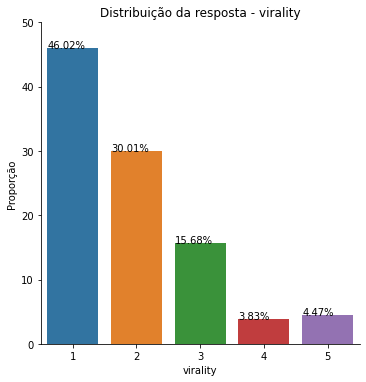

In [17]:
df = train_tweets
df.head()
x,y = 'index', 'virality'

df1 = df[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',kind='bar',data=df1)
g.ax.set_ylim(0,50)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    
plt.title("Distribuição da resposta - virality")
plt.xlabel("virality")
plt.ylabel("Proporção")
plt.show()

Podemos ver que os dados apresentam um desbalanceamento considerável em relação à variável resposta, sendo tweets mais virais menos frequêntes que tweets menos virais na base.

Ainda, apresentamos algumas medidas destritivas do dataset train_tweets.

In [18]:
train_tweets.describe()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_language_id,virality
count,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000
mean,21136.827477,27.489755,2019.005705,7.045536,15.814717,15.048236,1.054008,1.218903,0.641283,0.153181,1.907274
std,12160.900255,16.271052,1.447595,3.527015,8.872990,5.188924,1.126270,0.985059,1.011227,1.245717,1.078700
min,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,10639.000000,14.000000,2019.000000,4.000000,8.000000,13.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,21113.000000,27.000000,2019.000000,7.000000,16.000000,16.000000,1.000000,1.000000,0.000000,0.000000,2.000000
75%,31645.000000,42.000000,2020.000000,10.000000,24.000000,19.000000,2.000000,2.000000,1.000000,0.000000,2.000000
max,42323.000000,55.000000,2021.000000,12.000000,31.000000,23.000000,14.000000,8.000000,16.000000,30.000000,5.000000


Em seguida, fazemos alguns boxplots para verificação de outliers e para a averiguação de como estão destribuídos os atritudos numéricos do data.frame train_tweets.

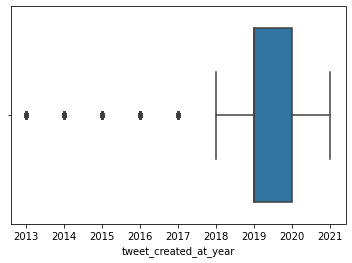

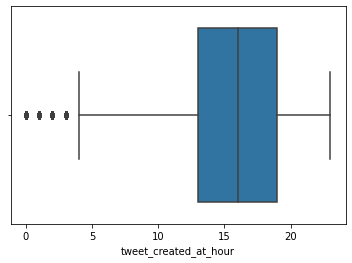

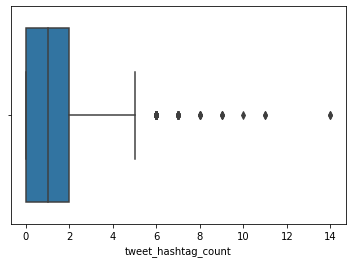

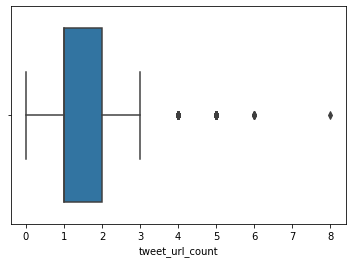

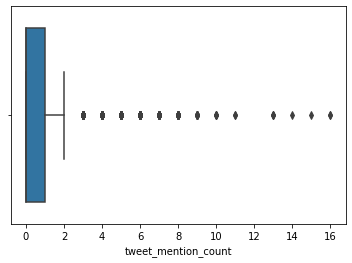

In [19]:
for col in ['tweet_created_at_year', 'tweet_created_at_hour', 'tweet_hashtag_count',
            'tweet_url_count',  'tweet_mention_count']:
    sns.boxplot(x = train_tweets[col])
    plt.show()

Com os box-plots, não encontramos nenhum valor outlier que esteja fora do normal de acordo com os atributos.

Abaixo apresentamos uma matriz de correlação dos dados dos tweets.

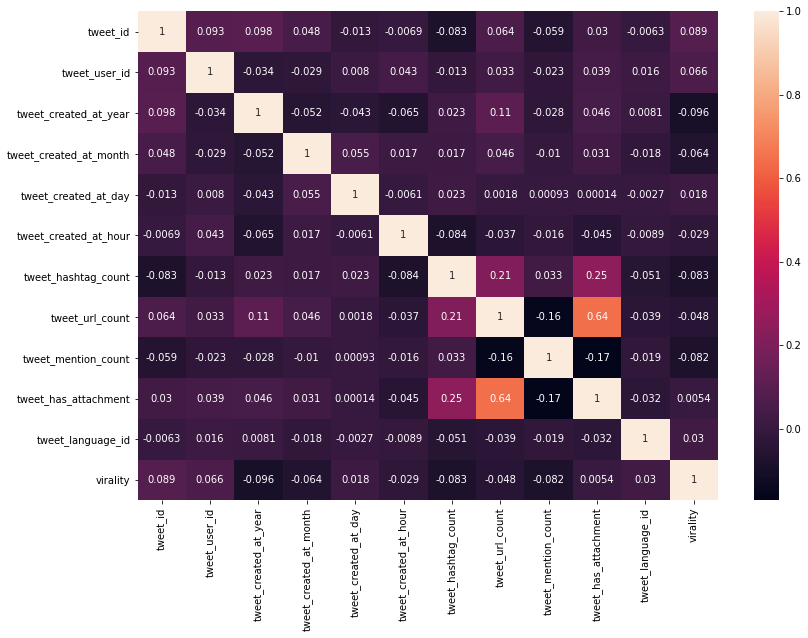

In [74]:
plt.figure(figsize=(13, 9))
       
corrMatrix = train_tweets.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Não encontramos nenhuma correlação muito forte entre as features.

### 1.1 Users

Agora, será desenvolvida uma análise para os dados relacionados aos usuários.

Vejamos abaixo as dimensões dos datasets relacionados aos Usuários.

In [75]:
user_vectorized_profile_images.shape

(52, 2049)

In [76]:
user_vectorized_descriptions.shape

(52, 769)

In [77]:
users.shape

(52, 11)

In [78]:
users

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8
4,4,15311,459083,1021,7368,False,121193,False,0,2011,6
5,5,882,5969,2352,841,True,3184,False,0,2011,1
6,6,4736,23127,1345,909,False,12033,True,0,2011,1
7,7,0,103254,529,990,True,169,True,0,2014,11
8,8,7776,168167,11290,1816,True,7065,True,0,2013,4
9,10,9365,398591,136081,18462,True,169980,True,0,2011,10


Segue abaixo a estimativa kernel das distribuições dos atributos relacionados aos usuários.

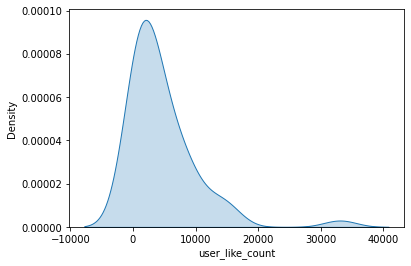

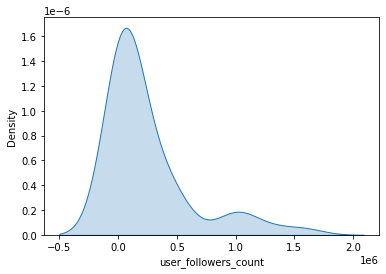

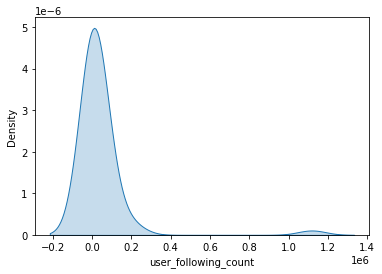

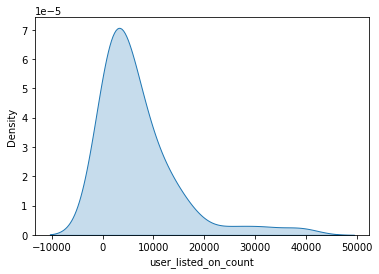

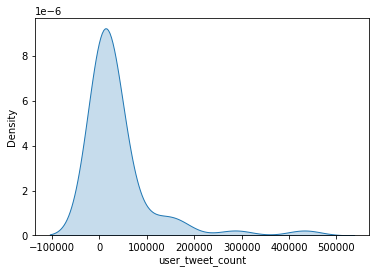

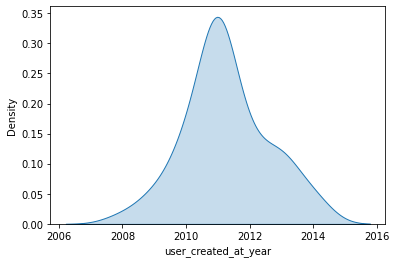

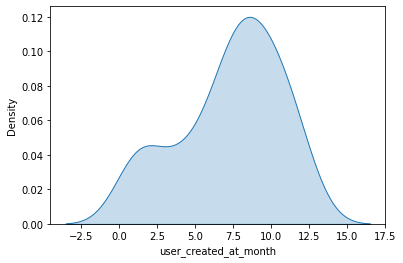

In [79]:
for  col in ['user_like_count', 'user_followers_count',
             'user_following_count', 'user_listed_on_count',
             'user_tweet_count', 'user_created_at_year',
             'user_created_at_month']:
    sns.kdeplot(data=users, x = col, fill="stack")
    plt.show()

Vemos que nenhum atributo possui uma distribuição muito singular. A maioria deles são distribuições de forma assimétrica à direita.


Abaixo temos a matriz de correlação dos atributos relacionados aos usuários.

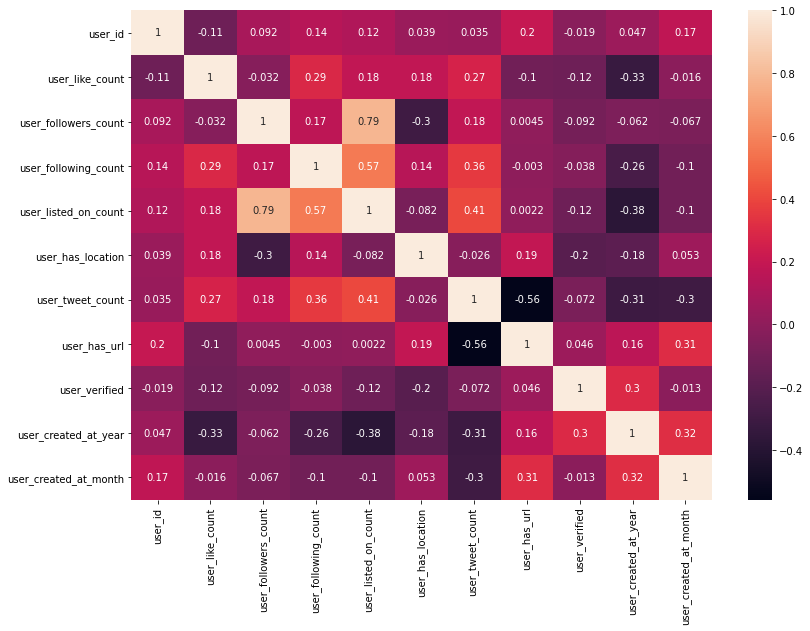

In [80]:
plt.figure(figsize=(13, 9))

corrMatrix = users.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### 1.2 Juntando os dados

#### 1.2.1 Funções

A função MergeMedias foi criada para fazer a média dos atributos das midias de cada tweet_id, pois não foi possível concatenar todas as midias de cada tweet. Se fizéssemos isso, haveria muitos atributos esparsos na matriz de atributos de tweets. Assim, decidimos trabalhar com a média dos tweets. Entretanto, não notamos melhoras nos classificadores e até fizemos um teste para verificar se apenas os atribubos médios das midias seriam capazes de idenficar tweets virais. Para a nossa surpresa, todos os classificadores testados predizeram apenas a viralidade "1". Logo, concluímos que os atributos das midias não acrescentam informação útil para a classificação da viralidade dos tweets.
**Com base nesta análise, decidimos não trabalhar com os atributos das medias**.

In [20]:
def MergeMedias(media,tweets):
    tweet_id = tweets.tweet_id.values
    
    names = media.columns[1:]
    tempmatrix = np.zeros((len(tweet_id),len(names)))   
    num_imagens = [0]*len(tweet_id)
    for i in media.index:
        index = np.where(tweet_id == media["tweet_id"].iloc[i])[0][0]
        j = num_imagens[index]
        tempmatrix[index,] += media.iloc[i,1:]
        num_imagens[index] += 1
        
    for i in np.arange(tweet_id.shape[0]):
        if (num_imagens[i]>1):
            tempmatrix[i,:] /= num_imagens[i]

    newmedia = pd.DataFrame(tempmatrix, index=range(tempmatrix.shape[0]), columns=names)
    newmedia["tweet_id"] = tweet_id

    return newmedia

#### 1.2.2 User

Combina os dados dos usuários antes de juntar com os dados dos tweets.

In [21]:
#Junta as tabelas
users = users.merge(user_vectorized_descriptions, on = "user_id", how = "left")
users = users.merge(user_vectorized_profile_images, on = "user_id", how = "left")

#### 1.2.3 Combinando dados

In [22]:
#Juntando dados dos tweets
train_tweets = train_tweets.merge(train_tweets_vectorized_text, on = "tweet_id", how = "left")
test_tweets = test_tweets.merge(test_tweets_vectorized_text, on = "tweet_id", how = "left")

In [23]:
train = pd.merge(train_tweets, users, how='left', left_on='tweet_user_id', right_on='user_id')
train.drop(["tweet_id", "user_id", "tweet_user_id"], axis = 1, inplace = True)

test = pd.merge(test_tweets, users, how='left', left_on='tweet_user_id', right_on='user_id')
testId = test.loc[:, "tweet_id"]
test.drop(["tweet_id", "user_id", "tweet_user_id"], axis = 1, inplace = True)

Como temos que a variável `tweet_topic_ids` é categórica com muitas classes e pretendemos transforma-la em Dummies, optamos por excluí-la da análise, pois ela retornará muitas colunas com valores 0.

In [24]:
#Remove a coluna tweet_topic_ids, pq tava gastando muito tempo pra tentar limpar ela
# e já conseguimos um resultado muito satisfatório sem ela, como será visto na sequência.
train.drop("tweet_topic_ids", axis = 1, inplace = True)
test.drop("tweet_topic_ids", axis = 1, inplace = True)

Converte a única variável categórica do nosso conjunto em numérica, usando o comando `get_dummies`.

In [25]:
#Dummy 
train = pd.concat([train, pd.get_dummies(train.tweet_attachment_class)], axis = 1) 
train.drop("tweet_attachment_class", axis = 1, inplace = True)

test = pd.concat([test, pd.get_dummies(test.tweet_attachment_class)], axis = 1) 
test.drop("tweet_attachment_class", axis = 1, inplace = True)

In [26]:
for col_name in train.columns: 
    print(col_name)

tweet_created_at_year
tweet_created_at_month
tweet_created_at_day
tweet_created_at_hour
tweet_hashtag_count
tweet_url_count
tweet_mention_count
tweet_has_attachment
tweet_language_id
virality
feature_0
feature_1
feature_2
feature_3
feature_4
feature_5
feature_6
feature_7
feature_8
feature_9
feature_10
feature_11
feature_12
feature_13
feature_14
feature_15
feature_16
feature_17
feature_18
feature_19
feature_20
feature_21
feature_22
feature_23
feature_24
feature_25
feature_26
feature_27
feature_28
feature_29
feature_30
feature_31
feature_32
feature_33
feature_34
feature_35
feature_36
feature_37
feature_38
feature_39
feature_40
feature_41
feature_42
feature_43
feature_44
feature_45
feature_46
feature_47
feature_48
feature_49
feature_50
feature_51
feature_52
feature_53
feature_54
feature_55
feature_56
feature_57
feature_58
feature_59
feature_60
feature_61
feature_62
feature_63
feature_64
feature_65
feature_66
feature_67
feature_68
feature_69
feature_70
feature_71
feature_72
feature_73
feat

feature_1750
feature_1751
feature_1752
feature_1753
feature_1754
feature_1755
feature_1756
feature_1757
feature_1758
feature_1759
feature_1760
feature_1761
feature_1762
feature_1763
feature_1764
feature_1765
feature_1766
feature_1767
feature_1768
feature_1769
feature_1770
feature_1771
feature_1772
feature_1773
feature_1774
feature_1775
feature_1776
feature_1777
feature_1778
feature_1779
feature_1780
feature_1781
feature_1782
feature_1783
feature_1784
feature_1785
feature_1786
feature_1787
feature_1788
feature_1789
feature_1790
feature_1791
feature_1792
feature_1793
feature_1794
feature_1795
feature_1796
feature_1797
feature_1798
feature_1799
feature_1800
feature_1801
feature_1802
feature_1803
feature_1804
feature_1805
feature_1806
feature_1807
feature_1808
feature_1809
feature_1810
feature_1811
feature_1812
feature_1813
feature_1814
feature_1815
feature_1816
feature_1817
feature_1818
feature_1819
feature_1820
feature_1821
feature_1822
feature_1823
feature_1824
feature_1825
feature_1826

### 1.3 Boxplot de alguns atributos em função da viralidade

#### 1.3.1 user_like_count

<AxesSubplot:xlabel='virality', ylabel='user_like_count'>

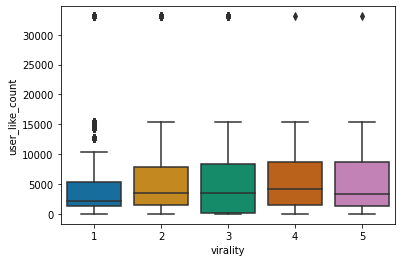

In [33]:
sns.boxplot(y='user_like_count', x='virality', 
                 data=train, 
                 palette="colorblind")

#### 1.3.2 tweet_hashtag_count

<AxesSubplot:xlabel='virality', ylabel='tweet_hashtag_count'>

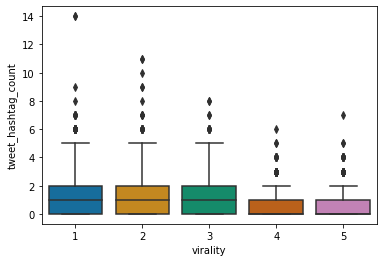

In [30]:
sns.boxplot(y='tweet_hashtag_count', x='virality', 
                 data=train, 
                 palette="colorblind")

#### 1.3.3 user_followers_count

<AxesSubplot:xlabel='virality', ylabel='user_followers_count'>

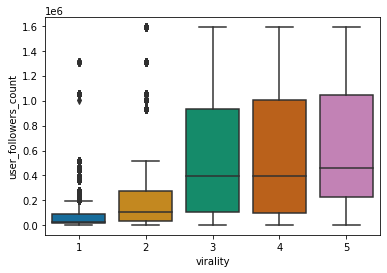

In [32]:
sns.boxplot(y='user_followers_count', x='virality', 
                 data=train, 
                 palette="colorblind")

#### 1.3.4 user_tweet_count

<AxesSubplot:xlabel='virality', ylabel='user_tweet_count'>

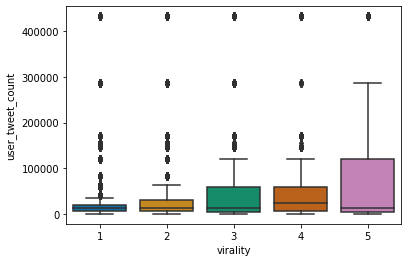

In [35]:
sns.boxplot(y='user_tweet_count', x='virality', 
                 data=train, 
                 palette="colorblind")

In [87]:
print(train.shape)
print(test.shape)

(29625, 3607)
(12697, 3606)


## 2. Redução de dimensionalidade e treinamento de modelos.

Dado a dimensão dos dados ser muito grande, vamos utilizar alguns métodos diferentes visando reduzir a dimensionalidade. Após reduzirmos  a dimensionalidade, vamos trainar e validar os modelos, para ver qual método produz um resultado melhor.


### 2.1 PCA

Pela grande dimensionalidade do conjunto (3606 atributos), decidimos aplicar PCA em todos os atributos do nosso conjunto, como uma forma de reduzir a dimensionalidade para podermos utilizar em modelos e fazer as análises que queremos.

In [89]:
columns = train.columns.values

y_columns = ["virality"]
x_columns = [x for x in columns if x != "virality"]

X = train[x_columns]
y = train[y_columns]

#PCA
pca = PCA(n_components = 500)

pca.fit(X)

X_PCA = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2, stratify = y)
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y, test_size = 0.2, random_state = 2, stratify = y)

Embora a variância seja explicada apenas pelos primeiros dez componentes, decidimos manter os 500 primeiros, pois o nosso receio era perder informação importante para a classificação que não foi captada pelos primeiros componentes. Como os atributos são muito diversos, incluindo desde informação dos tweets (texto), como informação do usuário (número de seguidores, número de likes, imagem do profile, entre outros), usando apenas os primeiros componentes limitaria o tipo de informação contida neles. Isso poderia deixar de fora informação importante, cuja variância é baixa. Verificamos essa hipótese testando os modelos com o número de componentes entre 10 e 500. Os melhores resultados no treinamento foi com 500 componentes.

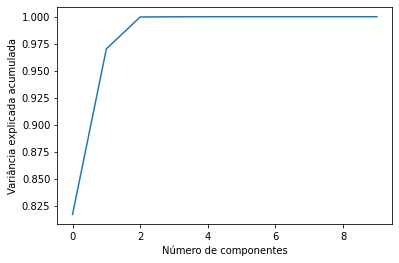

In [90]:
#Plot variância explicada acumulada
plt.plot(np.cumsum(pca.explained_variance_ratio_[0:10]))
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada');

Como podemos ver pelo gráfico acima, temos que apenas com 2 componentes principais já conseguimos explicar quase 100% da variabilidade dos nossos dados.

#### 2.1.1 Treinando e validando modelos com PCA

Ajuste dos hiperparâmetros do modelo XGBoost (comentado devido à demora em executá-lo).

In [35]:
# # hiperparametros para ajustar
# param_grid = {
#         'min_child_weight': [3, 9, 18],
#         'gamma': [1, 3, 6, 9],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5],
#         'n_estimators': [90,100,180],
#         }

# param_grid = {
#         'n_estimators': [180],
#         }

# gs_ab = GridSearchCV(XGBClassifier(), param_grid = param_grid, n_jobs=8, scoring = "accuracy")

# gs_ab.fit(X_train_PCA,y)

# print('Melhores parâmetros:', gs_ab.best_params_)

In [91]:
# #model = XGBClassifier(colsample_bytree = gs_ab.best_params_['colsample_bytree'], gamma = gs_ab.best_params_['gamma'],
# #                      max_depth = gs_ab.best_params_['max_depth'], min_child_weight= gs_ab.best_params_['min_child_weight'],  subsample = gs_ab.best_params_['subsample'] )

model = XGBClassifier(n_estimators = 180)

model.fit(X_train_PCA, y_train.to_numpy().ravel())

y_pred = model.predict(X_test_PCA)
print("Acc. Score: {}".format(accuracy_score(y_test, y_pred)))

C:\Users\PaulinoVillas-Boas\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acc. Score: 0.6656540084388186


### 2.2 LDA

Ao utilizarmos o LDA, temos uma abordagem muito semelhante ao PCA, onde reduzimos a dimensionalidade por meio de uma transformação linear, porém, considerando as classes.

In [93]:
lda = LinearDiscriminantAnalysis(n_components=4)

lda.fit(X_train,y_train)
y_pred = lda.predict(X_test)
print(lda.score(X_test,y_test))

C:\Users\PaulinoVillas-Boas\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6514767932489451


### 2.3 Univariate Feature Selection

Ainda levando em conta a grande dimensionalidade do conjunto, decidimos testar outra abordagem, que seria a de seleção de features univariada (dado que a recursiva nesse nosso caso seria inviável devido a quantidade de atributos). Primeiramente testamos a seleção de feature com a função score f_classif





In [94]:
X_train.shape

(23700, 3606)

In [96]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif 

test = SelectKBest(score_func = f_classif, k=10)
fit = test.fit(X_train, y_train)

mask = fit.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train.columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat))

C:\Users\PaulinoVillas-Boas\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The best features are:['user_followers_count', 'feature_766_y', 'feature_826', 'feature_1069', 'feature_1232', 'feature_1245', 'feature_1279', 'feature_1584', 'feature_1909', 'feature_1933']


C:\Users\PaulinoVillas-Boas\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [2592 3404] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\PaulinoVillas-Boas\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Segue abaixo os dados com as features que o método retornou

In [101]:
X_train1 = X_train.loc[:,new_feat]
X_test1 = X_test.loc[:,new_feat]

Também utilizamos a função mutual_info_classif

In [104]:
test = SelectKBest(score_func = mutual_info_classif, k=10)
fit = test.fit(X_train, y_train)

mask = fit.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X_train.columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat))

C:\Users\PaulinoVillas-Boas\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The best features are:['user_following_count', 'feature_40_y', 'feature_74_y', 'feature_124_y', 'feature_517_y', 'feature_928', 'feature_1176', 'feature_1227', 'feature_1322', 'feature_1910']


Segue abaixo os dados com as features que o método retornou

In [105]:
X_train2 = X_train.loc[:,new_feat]
X_test2 = X_test.loc[:,new_feat]

#### 2.3.1 Treinando e validando modelos com Feature Selection Univariada

Avaliando acurácia com os dados obtidos da feature selection com função 
f_classif

In [103]:
model = XGBClassifier(n_estimators = 180)
model.fit(X_train1, y_train.to_numpy().ravel())
y_pred1 = model.predict(X_test1)
print("Acc. Score: {}".format(accuracy_score(y_test, y_pred1)))

[23:58:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acc. Score: 0.6369620253164557


Avaliando acurácia com os dados obtidos da feature selection com função 
mutual_info_classif

In [107]:
model = XGBClassifier(n_estimators = 180)
model.fit(X_train2, y_train.to_numpy().ravel())
y_pred2 = model.predict(X_test2)
print("Acc. Score: {}".format(accuracy_score(y_test, y_pred2)))

C:\Users\PaulinoVillas-Boas\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acc. Score: 0.6369620253164557


Como podemos ver, a acurácia obtida utilizando a seleção de features (com ambas as funções) e o LDA se saiu inferior ao resultado de quando utilizamos o PCA, portanto, vamos seguir com a abordagem utilizando PCA para classificarmos no conjunto de teste.

## 3. Resultado público do conjunto de teste

![alt text](df2cef56-2b05-4079-a724-ac331740e0cd.jpg "Resultado do bitgrit")

## 4. Conclusão

Neste trabalho, desenvolvemos algumas estratégias para a classificação do nível de viralidade dos tweets. A maior dificuldade deste trabalho foi lidar com um número elevado de atributos, muito dos quais não tinham uma relação clara com o nível de viralidade dos tweets. Assim, testamos dois métodos de redução de dimensionalidade: PCA e LDA. O primeiro transforma as variáveis preditoras em componentes com as mairores variâncias dos dados de forma descrescente. O segundo é similar ao primeiro, mas também leva em conta as classes dos dados para determinar os eixos de transformação. Também testamos dois métodos de seleção de atributos f_classif e mutual_info_classif para usar nos classificadores.

Devido ao volume enorme de dados do problema, optamos por testar apenas o modelo de classificação XGBoost no espaço reduzido de atributos. No caso da redução por LDA, também usamos esse método para classificar a viralidade dos tweets. Além disso, decidimos não usar os dados das mídias porque não conseguimos boa acurácia, usando apenas estes dados.

Com estas estratégias, conseguimos uma acurácia de quase 67\% no conjunto de teste separado do conjunto de treinamento usando o modelo XGBoost com PCA. O modelo LDA também apresentou um bom resultado, ficando em 66\%. Os resultados do XGBoost com a seleção de atributos ficou em torno de 64\%. Na submissão do `bitgrit`, conseguimos uma acurácia de 67.5\% usando o modelo XGBoost com PCA de 500 componentes.

Foi interessante participar de uma competição real, porém não tivemos tempo suficiente para explorar melhor outras estratégias de engenharia de atributos nem outros modelos de redução de atributos que levam em conta a variável preditora, como o próprio LDA. Além disso, como a base de dados era muito grande, muitos dos algoritmos que estávamos testando levaram horas para executar, limitando assim nossa capacidade de testar outras estratégias.